Processing dataset ...


  0%|          | 0/234 [00:00<?, ?it/s]

... done. Total 60000 data entries.
torch.Size([256, 200])
torch.Size([256, 200])


  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([256, 1])) must be the same as input size (torch.Size([256, 200]))

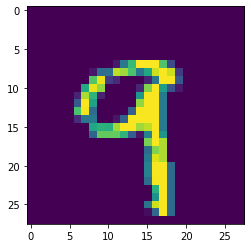

In [4]:
import struct

import matplotlib

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm



import torch

import torch.optim as optim

import torch.nn as nn

import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision import transforms

from torchvision.utils import save_image



from hw5_utils import BASE_URL, download, GANDataset



class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

class DNet(nn.Module):

    """This is discriminator network."""


    
    def __init__(self):

        super(DNet, self).__init__()

        

        # TODO: implement layers here

        self.f = nn.Sequential(

            nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=True),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1, bias=True),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=0, bias=True),

            nn.ReLU(),

            nn.Flatten(),
            
            PrintLayer(),

            #nn.Linear(8*5*5, 1, bias=True)

        )



        self._weight_init()



    def _weight_init(self):

        # TODO: implement weight initialization here

        for child in list(self.f.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



    def forward(self, x):

        # TODO: complete forward function
        f = self.f(x)
        
        return self.f(x)





class GNet(nn.Module):

    """This is generator network."""



    def __init__(self, zdim):

        """

        Parameters

        ----------

            zdim: dimension for latent variable.

        """

        super(GNet, self).__init__()



        # TODO: implement layers here

        self.f1 = nn.Sequential(

            nn.Linear(zdim, 1568, bias=True),

            nn.LeakyReLU(0.2)

        )

        self.f2 = nn.Sequential(

            nn.Upsample(scale_factor=2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),

            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),

            nn.LeakyReLU(0.2),

            nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1, bias=True),

            nn.Sigmoid()

        )



        self._weight_init()



    def _weight_init(self):

        # TODO: implement weight initialization here

        for child in list(self.f1.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



        for child in list(self.f2.children()):

            if isinstance(child, nn.Conv2d) or isinstance(child, nn.Linear):

                nn.init.kaiming_uniform_(child.weight.data)

                nn.init.zeros_(child.bias.data)



    def forward(self, z):

        """

        Parameters

        ----------

            z: latent variables used to generate images.

        """

        # TODO: complete forward function

        hidden = self.f1(z)

        return self.f2(hidden.view(-1, 32, 7, 7))





class GAN:

    def __init__(self, zdim=64):

        """

        Parameters

        ----------

            zdim: dimension for latent variable.

        """

        torch.manual_seed(2)

        self._dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")



        self._zdim = zdim

        self.disc = DNet().to(self._dev)

        self.gen = GNet(self._zdim).to(self._dev)



    def _get_loss_d(self, batch_size, batch_data, z):

        """This function computes loss for discriminator.



        Parameters

        ----------

            batch_size: #data per batch.

            batch_data: data from dataset.

            z: random latent variable.

        """

        # TODO: implement discriminator's loss function

        # pos_weight = torch.ones([batch_size])



        criterion = torch.nn.BCEWithLogitsLoss()



        loss_real = criterion(self.disc(batch_data), torch.ones((batch_size, 1), device=self._dev))

        loss_fake = criterion(self.disc(self.gen(z)), torch.zeros((batch_size, 1), device=self._dev))



        loss_d = (loss_real + loss_fake) / 2

        return loss_d



    def _get_loss_g(self, batch_size, z):

        """This function computes loss for generator.



        Parameters

        ----------

            batch_size: #data per batch.

            z: random latent variable.

        """

        # TODO: implement generator's loss function

        criterion = torch.nn.BCEWithLogitsLoss()



        loss_g = criterion(self.disc(self.gen(z)), torch.ones((batch_size, 1), device=self._dev))

        return loss_g



    def train(self, iter_d=1, iter_g=1, n_epochs=100, batch_size=256, lr=0.0002):



        # first download

        f_name = "train-images-idx3-ubyte.gz"

        download(BASE_URL + f_name, f_name)



        print("Processing dataset ...")

        train_data = GANDataset(

            f"./data/{f_name}",

            self._dev,

            transform=transforms.Compose([transforms.Normalize((0.0,), (255.0,))]),

        )

        print(f"... done. Total {len(train_data)} data entries.")



        train_loader = DataLoader(

            train_data,

            batch_size=batch_size,

            shuffle=True,

            num_workers=0,

            drop_last=True,

        )



        dopt = optim.Adam(self.disc.parameters(), lr=lr, weight_decay=0.0)

        dopt.zero_grad()

        gopt = optim.Adam(self.gen.parameters(), lr=lr, weight_decay=0.0)

        gopt.zero_grad()



        for epoch in tqdm(range(n_epochs)):

            for batch_idx, data in tqdm(

                enumerate(train_loader), total=len(train_loader)

            ):



                z = 2 * torch.rand(data.size()[0], self._zdim, device=self._dev) - 1



                if batch_idx == 0 and epoch == 0:

                    plt.imshow(data[0, 0, :, :].detach().cpu().numpy())

                    plt.savefig("goal.pdf")



                if batch_idx == 0 and epoch % 10 == 0:

                    with torch.no_grad():

                        tmpimg = self.gen(z)[0:64, :, :, :].detach().cpu()

                    save_image(

                        tmpimg, "test_{0}.png".format(epoch), nrow=8, normalize=True

                    )



                dopt.zero_grad()

                for k in range(iter_d):

                    loss_d = self._get_loss_d(batch_size, data, z)

                    loss_d.backward()

                    dopt.step()

                    dopt.zero_grad()



                gopt.zero_grad()

                for k in range(iter_g):

                    loss_g = self._get_loss_g(batch_size, z)

                    loss_g.backward()

                    gopt.step()

                    gopt.zero_grad()



            print(f"E: {epoch}; DLoss: {loss_d.item()}; GLoss: {loss_g.item()}")





if __name__ == "__main__":

    gan = GAN()

    gan.train()

